# Sentiment Classification

Instead of using an unsupervised method like VADER for sentiment analysis, I will create a model that will try to predict the sentiment of a review with supervised learning methods.

In [210]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from ast import literal_eval

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from sklearn.pipeline import Pipeline

import spacy
import contractions
import re

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

In [2]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [3]:
#data = pd.read_csv('data/processed_reviews.csv')

In [275]:
data = pd.read_csv('data/cleaned_reviews.csv', converters = {'cleaned_text_sent': literal_eval})

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133546 entries, 0 to 133545
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   reviews            133546 non-null  object
 1   sentiment          133546 non-null  int64 
 2   cleaned_text       133546 non-null  object
 3   dominant_topic     133546 non-null  int64 
 4   cleaned_text_sent  133546 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.1+ MB


In [5]:
data.head()

,reviews,sentiment,cleaned_text,dominant_topic,cleaned_text_sent
0,"Get the SportaPros instead. They look better,...",1,"['instead', 'look', 'well', 'wear', 'street', ...",4,"[sportapros, instead, look, well, wear, street..."
1,I've been looking for a lighter alternative to...,1,"['look', 'light', 'alternative', 'absolutely',...",2,"[look, light, alternative, absolutely, perfect..."
2,The finest headphones available. You can spend...,1,"['fine', 'headphone', 'available', 'spend', 'v...",2,"[fine, headphone, available, spend, vast, amou..."
3,3rd pair of these I've purchased. My wife has...,1,"['pair', 'purchase', 'wife', 'pair', 'pair', '...",3,"[rd, pair, purchase, wife, pair, pair, glove, ..."
4,My old Koss Porta Pros finally got beat to dea...,1,"['old', 'finally', 'get', 'beat', 'death', 'ye...",4,"[old, koss, porta, pros, finally, get, beat, d..."


In [6]:
data.sentiment.value_counts(normalize = True)

1    0.766582
0    0.233418
Name: sentiment, dtype: float64

## Text Cleaning for sentiment analysis

I will need to modify the text cleaning process for sentiment analysis. Negation words such as not and no are usually removed by standard stop word lists. These negations may not have made a big difference for topic modeling, but they can change the sentiment of a statement depending on if they are removed or not. For example the phrase "Not great, do not buy" is a negative statement. But after removal of standard stop words the statment will be "great buy", which can be seen as positive.

In [106]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [107]:
len(stop_words)

326

In [ ]:
# list for words to remove from stop_words
stop_list = ['cannot', 'not', 'nor', 'no']

In [ ]:
for item in stop_list:
    # Add the word to the set of stop words.
    nlp.Defaults.stop_words.remove(item)
    
    # Set the stop_word tag on the lexeme
    nlp.vocab[item].is_stop = False

In [109]:
len(stop_words)

326

Another step I will be adding is to expand conractions. This will allow me to preserve 'not' tokens. For this i will be using the contractions library that expands contractions with below simple code.

In [111]:
contractions.fix('wont cant dont')

'will not cannot do not'

In [142]:
def clean_text(text):
    # Replace &nbsp; with regular space
    text = text.replace("&nbsp;", " ")
    # Remove HTML tags and attributes
    text = re.sub(r"<[^>]+>", "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove line breaks and extra whitespace
    text = re.sub(r"\s+", " ", text)
    # Expand contractions
    text = contractions.fix(text)
    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase and remove leading/trailing white space
    # Tokenize and lemmatize, keep words with length greater than 1
    doc = nlp(text)
    lemmas = [token.lemma_.lower().strip() for token in doc if not token.is_punct and not token.is_stop and len(token) > 1]
    
    return lemmas

In [110]:
# sample review to test clean function
data.reviews[132512]

"I got these headphones as a xmas for my wife (yeah for me too). I own multiple pairs of corded headphones and one other pair of cheap bluetooth headphones (Kinivo BTH240). My daily go to headphones are a pair of Sennheiser hd 280 pro cans and I have a pair of Audio-Technica ATH-M30 that I use at work.\n\nRatings:\n\nSound: 8/10\n\nThe sound is fairly detailed and well balanced. The bass end is not overpowering nor underwhelming. Midrange is clear and distinct. High end has detail and it is not too tinny. YMMV. I would say, for the headphones I use, the sound reproduction is somewhere between my Audio-Technica ATH-M30 but not quite as good as my Sennheiser hd 280. Which is on par for the price range they are in. Come on people, stop comparing these to headphones that cost 3-5 times as much.\n\nComfort: 10/10\n\nThese fit over my ears well and these may very well be the most comfortable headphones I presently own. Most headphones I wear do not bother me much and these are no exception.\

In [143]:
clean_text(data.reviews[132512])

['get',
 'headphone',
 'xma',
 'wife',
 'yeah',
 'multiple',
 'pair',
 'cord',
 'headphone',
 'pair',
 'cheap',
 'bluetooth',
 'headphone',
 'kinivo',
 'bth',
 'daily',
 'headphone',
 'pair',
 'sennheiser',
 'hd',
 'pro',
 'can',
 'pair',
 'audiotechnica',
 'athm',
 'use',
 'work',
 'ratings',
 'sound',
 'sound',
 'fairly',
 'detailed',
 'balance',
 'bass',
 'end',
 'overpower',
 'underwhelme',
 'midrange',
 'clear',
 'distinct',
 'high',
 'end',
 'detail',
 'tinny',
 'ymmv',
 'headphone',
 'use',
 'sound',
 'reproduction',
 'audiotechnica',
 'athm',
 'good',
 'sennheiser',
 'hd',
 'par',
 'price',
 'range',
 'come',
 'people',
 'stop',
 'compare',
 'headphone',
 'cost',
 'time',
 'comfort',
 'fit',
 'ear',
 'comfortable',
 'headphone',
 'presently',
 'headphone',
 'wear',
 'bother',
 'exception',
 'build',
 'quality',
 'headphone',
 'solid',
 'feel',
 'lot',
 'like',
 'high',
 'end',
 'benz',
 'car',
 'door',
 'time',
 'tell',
 'durable',
 'lot',
 'confidence',
 'noise',
 'cancellatio

In [ ]:
data['cleaned_text_sent'] = data.reviews.apply(lambda x: clean_text(x))

In [ ]:
#data.to_csv('data/cleaned_reviews.csv', index = False)

## Feature Engineering

Since my features are text data, before I can input into any models I will need to vectorize the text to be represented as numbers. I will test out various vectorizers and classification models to find the best performing model. 

Vectorizers:
* CountVectorizer
* TfidfVectorizer
* Word2Vec
* Pre-trained Glove

Classification Algorithms:
* Logistic Regression
* Naive Bayes
* Random Forest
* LSTM

## Data Preprocessing

Seperating target and features

In [156]:
# Changing sentiment to numerical values
data.replace({'sentiment':{'Negative': 0, 'Positve': 1}}, inplace = True)

In [160]:
data.sentiment.value_counts(normalize = True)

1    0.766582
0    0.233418
Name: sentiment, dtype: float64

In [7]:
X = data.cleaned_text_sent
y = data.sentiment

### Train Test Split

Splitting data to train and test sets with stratify to keep class percentages similar in both.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    stratify = y,
                                                    random_state = 42)

In [9]:
X_train.shape

(106836,)

In [10]:
X_test.shape

(26710,)

In [11]:
y_train.value_counts(normalize = True)

1    0.766586
0    0.233414
Name: sentiment, dtype: float64

In [12]:
y_test.value_counts(normalize = True)

1    0.766567
0    0.233433
Name: sentiment, dtype: float64

## Baseline Model

For our baseline model I will use logistic regression / countvectorizer and optimize for f1 score due to imbalanced dataset, as this metric will have a good balance of precision and recall.

## Count Vectorizer

Vectorizer used to create a bag of words model. Will create a matrix will all the words avaliable in the documents and the number of times they appear.

In [13]:
def dummy(doc):
    return doc

In [217]:
# Instantiate CountVectorizer with unigrams and bigrams
count_vect = CountVectorizer(ngram_range = (1,2), 
                             stop_words = None, 
                             tokenizer = dummy, 
                             preprocessor = dummy,
                             min_df = 10)

In [219]:
count_vect.fit(X_train)

CountVectorizer(min_df=10, ngram_range=(1, 2),
                preprocessor=<function dummy at 0x000001E74594C430>,
                tokenizer=<function dummy at 0x000001E74594C430>)

In [220]:
# Total vocabulary length
len(count_vect.get_feature_names())

64601

### Logistic Regression

In [221]:
logr = LogisticRegression(class_weight = 'balanced', solver = 'saga', max_iter = 1000)


In [222]:
cv_logr_model = Pipeline([
    ('countvec', count_vect),
    ('logreg', logr)
])

In [223]:
cv_logr = cross_validate(cv_logr_model, X_train, y_train, cv = 5, scoring = ['f1', 'precision', 'recall'])

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:

In [224]:
model_results = pd.DataFrame(columns=['Model', 'mean f1_score', 'std f1_score', 'mean precision', 'mean recall'])

In [225]:
model_results = model_results.append({'Model': 'cv_logr_model',
                      'mean f1_score': round(cv_logr['test_f1'].mean(), 4),
                      'std f1_score': round(cv_logr['test_f1'].std(), 4),
                      'mean precision': round(cv_logr['test_precision'].mean(), 4),
                      'mean recall': round(cv_logr['test_recall'].mean(), 4)}, ignore_index = True)

In [226]:
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.9248,0.0016,0.9352,0.9145


C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:

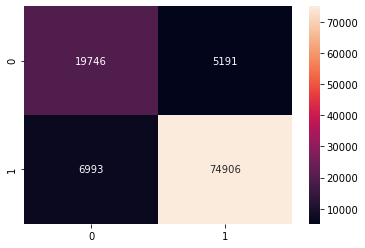

In [227]:
cv_logr_hat = cross_val_predict(cv_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, cv_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Decent results for a baseline model. f1 score of 92% was obtained. 

In [133]:
logr_cv_model.fit(X_train, y_train)

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('countvec',
                 CountVectorizer(preprocessor=<function dummy at 0x000001E74594C430>,
                                 tokenizer=<function dummy at 0x000001E74594C430>)),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga'))])

In [136]:
logr_cv_model.steps[1][1].coef_[0]

array([ 0.07583987,  0.34361272,  0.25439821, ..., -0.00201732,
        0.00045675,  0.03273963])

In [139]:
features = logr_cv_model.steps[1][1].coef_[0]

names = logr_cv_model['countvec'].get_feature_names()

dff = pd.DataFrame({'features': features, 'names': names})

dff.sort_values('features', ascending = False).head(10)

,features,names
9025,2.048368,charm
7129,1.973041,budge
1886,1.754057,ample
25102,1.722740,holy
45193,1.710818,remedy
21980,1.705805,goggle
19760,1.701909,fits
47154,1.696865,sanity
18104,1.691321,exceed
24866,1.691023,hint


In [140]:
dff.sort_values('features', ascending = True).head(10)

,features,names
57560,-2.437693,unacceptable
14384,-2.157037,disappointing
8642,-2.083052,cease
47071,-2.081539,sam
32748,-2.050582,meh
61790,-1.990861,womp
13300,-1.983314,defeat
14375,-1.983296,disappointed
62123,-1.930738,worse
58070,-1.926048,unimpressed


### Naive Bayes

In [228]:
mnb = MultinomialNB(class_prior = [0.23, 0.77])

In [229]:
cv_mnb_model = Pipeline([
    ('countvec', count_vect),
    ('mnb', mnb)
])

In [230]:
cv_mnb = cross_validate(cv_mnb_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

In [231]:
model_results = model_results.append({'Model': 'cv_mnb_model',
                      'mean f1_score': round(cv_mnb['test_f1'].mean(), 4),
                      'std f1_score': round(cv_mnb['test_f1'].std(), 4),
                      'mean precision': round(cv_mnb['test_precision'].mean(), 4),
                      'mean recall': round(cv_mnb['test_recall'].mean(), 4)}, ignore_index = True)

In [232]:
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.9248,0.0016,0.9352,0.9145
1,cv_mnb_model,0.9173,0.0012,0.9325,0.9026


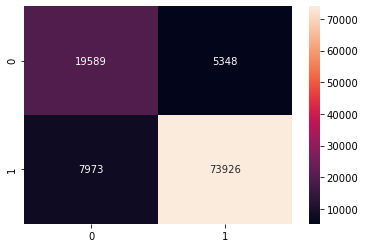

In [271]:
cv_mnb_hat = cross_val_predict(cv_mnb_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, cv_mnb_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

### Random Forest

In [272]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state=42)

In [273]:
cv_rf_model = Pipeline([
    ('countvec', count_vect),
    ('rf', rf)
])

In [274]:
cv_rf = cross_validate(cv_rf_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

KeyboardInterrupt: 

In [ ]:
model_results = model_results.append({'Model': 'cv_rf_model',
                      'mean f1_score': round(cv_rf['test_f1'].mean(), 4),
                      'std f1_score': round(cv_rf['test_f1'].std(), 4),
                      'mean precision': round(cv_rf['test_precision'].mean(), 4),
                      'mean recall': round(cv_rf['test_recall'].mean(), 4)}, ignore_index = True)
model_results

In [ ]:
cv_rf_hat = cross_val_predict(cv_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, cv_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

In [119]:
rfc_cv_model.fit(X_train, y_train)

Pipeline(steps=[('countvec',
                 CountVectorizer(preprocessor=<function dummy at 0x000001E74594C430>,
                                 tokenizer=<function dummy at 0x000001E74594C430>)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [125]:
features = rfc_cv_model.steps[1][1].feature_importances_

In [126]:
names = rfc_cv_model['countvec'].get_feature_names()

In [127]:
dff = pd.DataFrame({'features': features, 'names': names})

In [132]:
dff.sort_values('features', ascending = False).head(20)

,features,names
22460,0.023896,great
36781,0.021160,not
45789,0.013824,return
31226,0.009296,love
37550,0.007673,ok
41511,0.006662,poor
34269,0.006356,month
22046,0.006323,good
4159,0.006276,bad
18121,0.005911,excellent


## TF-IDF

One way to focus on more meaningful terms is to use TF-IDF Vectorizer. TF-IDF scores give more importance to terms that appear frequently in a certain document, but less frequent in all other documents. TF-IDF scores will be lower for words that appear frequently in all documents.

In [ ]:
tfidf = TfidfVectorizer(ngram_range = (1,2), 
                             stop_words = None, 
                             tokenizer = dummy, 
                             preprocessor = dummy,
                             min_df = 10)

In [ ]:
tfidf.fit(X_train)

In [ ]:
# Total vocabulary length
len(tfidf.get_feature_names())

### Logistic Regression

In [55]:
tfidf_logr_model = Pipeline([
    ('tfidfvec', tfidf),
    ('logreg', logr)
])

In [56]:
tfidf_logr = cross_validate(tfidf_logr_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

In [57]:
model_results = model_results.append({'Model': 'tfidf_logr_model',
                      'mean f1_score': round(tfidf_logr['test_f1'].mean(), 4),
                      'std f1_score': round(tfidf_logr['test_f1'].std(), 4),
                      'mean precision': round(tfidf_logr['test_precision'].mean(), 4),
                      'mean recall': round(tfidf_logr['test_recall'].mean(), 4)}, ignore_index = True)
model_results

In [ ]:
tfidf_logr_hat = cross_val_predict(tfidf_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, tfidf_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

### Naive Bayes

In [59]:
tfidf_mnb_model = Pipeline([
    ('tfidfvec', tfidf),
    ('mnb', mnb)
])

In [60]:
tfidf_mnb = cross_validate(tfidf_mnb_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

In [61]:
model_results = model_results.append({'Model': 'tfidf_mnb_model',
                      'mean f1_score': round(tfidf_mnb['test_f1'].mean(), 4),
                      'std f1_score': round(tfidf_mnb['test_f1'].std(), 4),
                      'mean precision': round(tfidf_mnb['test_precision'].mean(), 4),
                      'mean recall': round(tfidf_mnb['test_recall'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logreg_model,0.9073,0.0019,0.9371,0.8794
1,cv_mnb_model,0.9164,0.0017,0.8980,0.9355
2,cv_rf_model,0.9103,0.0007,0.8421,0.9904
3,tfidf_logreg_model,0.9055,0.0021,0.9463,0.8681
4,tfidf_mnb_model,0.8748,0.0003,0.7778,0.9993


In [ ]:
tfidf_mnb_hat = cross_val_predict(tfidf_mnb_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, tfidf_mnb_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

### Random Forest

In [62]:
tfidf_rf_model = Pipeline([
    ('tfidfvec', tfidf),
    ('rf', rf)
])

In [63]:
tfidf_rf = cross_validate(tfidf_rf_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

In [64]:
model_results = model_results.append({'Model': 'tfidf_rf_model',
                      'mean f1_score': round(tfidf_rf['test_f1'].mean(), 4),
                      'std f1_score': round(tfidf_rf['test_f1'].std(), 4),
                      'mean precision': round(tfidf_rf['test_precision'].mean(), 4),
                      'mean recall': round(tfidf_rf['test_recall'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logreg_model,0.9073,0.0019,0.9371,0.8794
1,cv_mnb_model,0.9164,0.0017,0.8980,0.9355
2,cv_rf_model,0.9103,0.0007,0.8421,0.9904
3,tfidf_logreg_model,0.9055,0.0021,0.9463,0.8681
4,tfidf_mnb_model,0.8748,0.0003,0.7778,0.9993
5,tfidf_rf_model,0.9109,0.0003,0.8440,0.9894


In [ ]:
tfidf_rf_hat = cross_val_predict(tfidf_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, tfidf_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

## Word Embeddings

The previous two vectorization strategies have only focused on term frequency. In order to try to capture semantic meaning of terms, we can use word embeddings. Using Word2Vec we can create word vector embeddings that can try to capture semantic relationships between words, if given enough data to train on.

In [236]:
# creating a w2v model
model = Word2Vec(X_train, size=100, window=5, min_count=1, workers=4)

In [237]:
# total reviews in train set
model.corpus_count

106836

In [238]:
# train model
model.train(X_train, total_examples=model.corpus_count, epochs=10)

(37519025, 44748080)

In [239]:
# get word vectors
wv = model.wv

In [69]:
wv.most_similar('great')

[('good', 0.7894223928451538),
 ('excellent', 0.7781077027320862),
 ('fantastic', 0.7535078525543213),
 ('awesome', 0.7460759878158569),
 ('amazing', 0.6775975227355957),
 ('nice', 0.6653569936752319),
 ('decent', 0.6346985101699829),
 ('terrific', 0.6300877332687378),
 ('wonderful', 0.6222761869430542),
 ('perfect', 0.6207687854766846)]

In [240]:
# Total vocabulary created 
len(wv.index2word)

63198

In [241]:
len(wv.vectors)

63198

In [242]:
# create a dictionary of words and vectors to plug into vectorizer pipeline
w2v = dict(zip(wv.index2word, wv.vectors))

Word vectors with a total vocabulary of 63198 has been created. We can check to see how well model is by checking similar words found by the model.

In [269]:
# testing w2v model by checking simlar word groupings

sample = ['feel', 'good', 'product', 'cheap', 'bad', 'great','price']

# loop through sample list and grab the top 5 most similar words
similar_words = {word: [item[0] for item in wv.most_similar([word], topn=5)]
                  for word in sample}
similar_words


{'feel': ['feeling', 'squeeze', 'material', 'structure', 'construction'],
 'good': ['decent', 'great', 'excellent', 'ok', 'well'],
 'product': ['item', 'company', 'seller', 'supplier', 'vendor'],
 'cheap': ['cheaply', 'expensive', 'cheep', 'cheapo', 'flimsy'],
 'bad': ['terrible', 'horrible', 'ok', 'awful', 'poor'],
 'great': ['good', 'excellent', 'fantastic', 'awesome', 'nice'],
 'price': ['cost', 'dollar', 'pricing', 'value', 'msrp']}

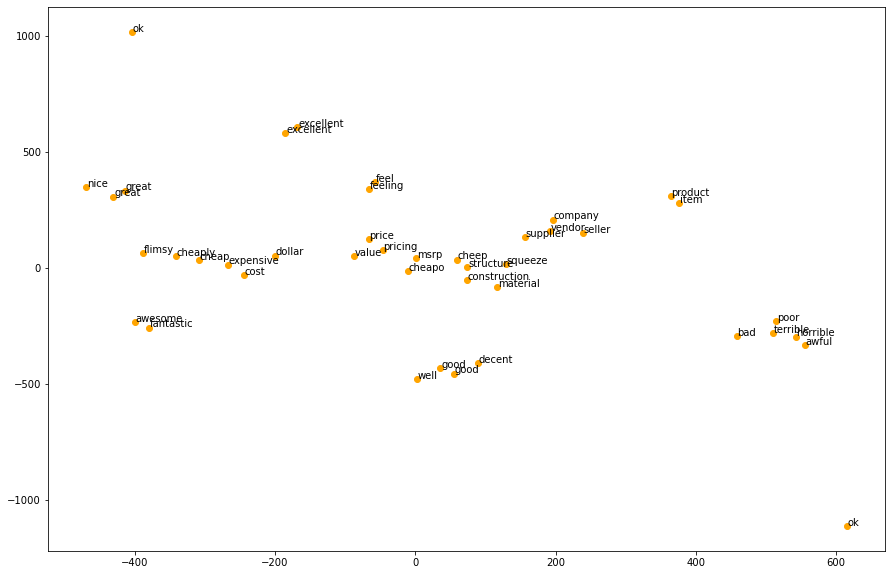

In [268]:
# concatenate sample and similar words
labels = sum([[k] + v for k, v in similar_words.items()], [])

# get vectors of all words
vec = wv[labels]

# reduce dimensionality of vectors to plot them
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(vec)

fig, ax = plt.subplots(figsize = (15,10))

ax.scatter(T[:, 0], T[:, 1], c='orange')

# label points
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    ax.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points', fontsize = 10)

Vectors created by w2v looks sensible. Words from our similar words search group together and are distinct from other groupings. Words similar to good are far away from words similar to bad.

### Mean Word embeddings

To make use of these individual word vectors for classification, we can compute the mean word embedding for each document. Basically we can take all the vectors represented by each word in a document and average them together in one single vector representing the document. This can help reduce dimensionality of features and make algorithms faster to execute.

In [264]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Naive Bayes does not take negative values for input, which some vectors created will have. I will skip MNB() classifer for these next steps to save some time on my part.

### Logistic Regression with Word2Vec

In [265]:
w2v_logr_model = Pipeline([
    ('w2v', W2vVectorizer(w2v)),
    ('logr', logr)
])

w2v_logr = cross_validate(w2v_logr_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

model_results = model_results.append({'Model': 'w2v_logr_model',
                      'mean f1_score': round(w2v_logr['test_f1'].mean(), 4),
                      'std f1_score': round(w2v_logr['test_f1'].std(), 4),
                      'mean precision': round(w2v_logr['test_precision'].mean(), 4),
                      'mean recall': round(w2v_logr['test_recall'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.9248,0.0016,0.9352,0.9145
1,cv_mnb_model,0.9173,0.0012,0.9325,0.9026
2,w2v_logr_model,0.8810,0.0015,0.9418,0.8275


In [ ]:
w2v_logr_hat = cross_val_predict(w2v_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, w2v_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

### Random Forest with Word2Vec

In [93]:
rfc_w2v_model = Pipeline([
    ('w2v', W2vVectorizer(w2v)),
    ('rf', rf)
])

w2v_rf = cross_validate(rfc_w2v_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

model_results = model_results.append({'Model': 'w2v_rf_model',
                      'mean f1_score': round(w2v_rf['test_f1'].mean(), 4),
                      'std f1_score': round(w2v_rf['test_f1'].std(), 4),
                      'mean precision': round(w2v_rf['test_precision'].mean(), 4),
                      'mean recall': round(w2v_rf['test_recall'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logreg_model,0.9073,0.0019,0.9371,0.8794
1,cv_mnb_model,0.9164,0.0017,0.8980,0.9355
2,cv_rf_model,0.9103,0.0007,0.8421,0.9904
3,tfidf_logreg_model,0.9055,0.0021,0.9463,0.8681
4,tfidf_mnb_model,0.8748,0.0003,0.7778,0.9993
5,tfidf_rf_model,0.9109,0.0003,0.8440,0.9894
6,w2v_logr_model,0.8806,0.0010,0.9413,0.8273
7,w2v_rf_model,0.9077,0.0008,0.8496,0.9742


In [ ]:
w2v_rf_hat = cross_val_predict(w2v_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, w2v_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

### Pre-trained word vectors with GloVe

Instead of training word embeddings, we can make use of weights from models that have been trained on massive amounts of text data. One popular model is GloVe, which has been trained on text data from wikipedia.

In [ ]:
# find total vocabulary of train set
total_vocabulary = set(word for review in X_train for word in review)

In [ ]:
len(total_vocabulary)

In [97]:
# get appropriate vectors from GloVe file, using 100 dimension vectors
glove = {}
with open('data/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [98]:
glove['great']

array([-0.013786 ,  0.38216  ,  0.53236  ,  0.15261  , -0.29694  ,
       -0.20558  , -0.41846  , -0.58437  , -0.77355  , -0.87866  ,
       -0.37858  , -0.18516  , -0.128    , -0.20584  , -0.22925  ,
       -0.42599  ,  0.3725   ,  0.26077  , -1.0702   ,  0.62916  ,
       -0.091469 ,  0.70348  , -0.4973   , -0.77691  ,  0.66045  ,
        0.09465  , -0.44893  ,  0.018917 ,  0.33146  , -0.35022  ,
       -0.35789  ,  0.030313 ,  0.22253  , -0.23236  , -0.19719  ,
       -0.0053125, -0.25848  ,  0.58081  , -0.10705  , -0.17845  ,
       -0.16206  ,  0.087086 ,  0.63029  , -0.76649  ,  0.51619  ,
        0.14073  ,  1.019    , -0.43136  ,  0.46138  , -0.43585  ,
       -0.47568  ,  0.19226  ,  0.36065  ,  0.78987  ,  0.088945 ,
       -2.7814   , -0.15366  ,  0.01015  ,  1.1798   ,  0.15168  ,
       -0.050112 ,  1.2626   , -0.77527  ,  0.36031  ,  0.95761  ,
       -0.11385  ,  0.28035  , -0.02591  ,  0.31246  , -0.15424  ,
        0.3778   , -0.13599  ,  0.2946   , -0.31579  ,  0.4294

In [99]:
len(glove)

26555

### Logistic Regression with GloVe

In [101]:
glove_logr_model = Pipeline([
    ('glove', W2vVectorizer(glove)),
    ('logr', logr)
])

In [102]:
glove_logr = cross_validate(glove_logr_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [103]:
model_results = model_results.append({'Model': 'glove_logr_model',
                      'mean f1_score': round(glove_logr['test_f1'].mean(), 4),
                      'std f1_score': round(glove_logr['test_f1'].std(), 4),
                      'mean precision': round(glove_logr['test_precision'].mean(), 4),
                      'mean recall': round(glove_logr['test_recall'].mean(), 4)}, ignore_index = True)

In [104]:
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logreg_model,0.9073,0.0019,0.9371,0.8794
1,cv_mnb_model,0.9164,0.0017,0.8980,0.9355
2,cv_rf_model,0.9103,0.0007,0.8421,0.9904
3,tfidf_logreg_model,0.9055,0.0021,0.9463,0.8681
4,tfidf_mnb_model,0.8748,0.0003,0.7778,0.9993
5,tfidf_rf_model,0.9109,0.0003,0.8440,0.9894
6,w2v_logr_model,0.8806,0.0010,0.9413,0.8273
7,w2v_rf_model,0.9077,0.0008,0.8496,0.9742
8,glove_logr_model,0.8211,0.0017,0.9151,0.7446


In [ ]:
glove_logr_hat = cross_val_predict(glove_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, glove_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

### Random Forest with GloVe

In [105]:
glove_rf_model = Pipeline([
    ('glove',  W2vVectorizer(glove)),
    ('rf', rf)
])

glove_rf = cross_validate(glove_rf_model, X_train, y_train, cv = 5, scoring = ['precision', 'recall', 'f1'])



model_results = model_results.append({'Model': 'glove_rf_model',
                      'mean f1_score': round(glove_rf['test_f1'].mean(), 4),
                      'std f1_score': round(glove_rf['test_f1'].std(), 4),
                      'mean precision': round(glove_rf['test_precision'].mean(), 4),
                      'mean recall': round(glove_rf['test_recall'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logreg_model,0.9073,0.0019,0.9371,0.8794
1,cv_mnb_model,0.9164,0.0017,0.8980,0.9355
2,cv_rf_model,0.9103,0.0007,0.8421,0.9904
3,tfidf_logreg_model,0.9055,0.0021,0.9463,0.8681
4,tfidf_mnb_model,0.8748,0.0003,0.7778,0.9993
5,tfidf_rf_model,0.9109,0.0003,0.8440,0.9894
6,w2v_logr_model,0.8806,0.0010,0.9413,0.8273
7,w2v_rf_model,0.9077,0.0008,0.8496,0.9742
8,glove_logr_model,0.8211,0.0017,0.9151,0.7446
9,glove_rf_model,0.8880,0.0002,0.8091,0.9839


In [ ]:
glove_rf_hat = cross_val_predict(glove_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, glove_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')